In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
from mppi.Utilities import LatticeUtils as LL
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
#code.global_options()

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',time='11:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.QeCalculator(rr,activate_BeeOND=True) #,skip=False,clean_restart=False
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': '11:59:00',
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'pw.x',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True}

In [5]:
# RunRules for m100
nodes = 1
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_AlNWS2',
                memory='120GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.QeCalculator(rr)
#code.global_options()

# DFT analysis of the 2D MoS$_2$

This notebook contains the DFT analysis of the 2D MoS$_2$ performed with QuantumESPRESSO

## Lattice properties and atomic positions

We use the lattice configuration adopted by QuantumESPRESSO in the ibrav=4 case.

The basis vector of the (direct) lattice are defined as
$$
a_1 = a_{lat}(1,0,0) \, ,\quad a_2 = a_{lat}(\frac{-1}{2},\frac{\sqrt{3}}{2},0) \, ,\quad
a_3 = a_{lat}(0,0,\frac{c}{a_{lat}})
$$
so that $c$ vacuum space between two replica of the sheets, expressed in the same units as $a_{lat}$.
We also observe that $\textrm{celldm(3)}=c/a_{lat}$, so it expresses the vacuum distance in terms of 
$a_{lat}$.

The cartesian component of the reciprocal lattice vectors (in units of $2\pi/a_{alat}$) are given by:

$$
b_1 = (1,\frac{1}{\sqrt{3}}) \, ,\quad b_2 = (0,\frac{2}{\sqrt{3}},0) \, ,\quad
b_3 = (0,0,\frac{a}{c})
$$
The reciprocal vectors have module $2/\sqrt{3}$.

The cartesian coordinates of the high symmetry points of the reciprocal lattice (in units of $2\pi/a_{alat}$) 
can be determined by performing the construction of the Brillouin zone: we find the points on at the half of
the $b_1$ and $b_2$ vectors and build the path moving perpendicularly to the basis vector directions.
The $M$ point (at the middle of the hexagon face) and the $K$ point (the edge point) are given by:
$$
M = (\frac{1}{2},\frac{1}{2\sqrt{3}}) \, \quad
K = (\frac{2}{3},0) 
$$
Moreover we write the coordinates of the symmetry related K' point (which corresponds to another edge of the hexagon)
and M' point (middle point of the top edge of the hexagon): 
$$
K' = (\frac{1}{3},\frac{1}{\sqrt{3}}) \, \quad
M' = (0,\frac{1}{\sqrt{3}}) 
$$
These points, together with $\Gamma$ define the IBZ edges in the representation of QuantumESPRESSO.

In cartesian coordinates the atomic positions read
$$
Mo = a_{lat}(0,\frac{1}{\sqrt{3}},0) \, \qquad S_1 = a_{lat}(\frac{1}{2},\frac{1}{2\sqrt{3}},\delta) \, \quad
S_2 = a_{lat}(\frac{1}{2},\frac{1}{2\sqrt{3}},-\delta)
$$
where $\delta$ is the buckling of the $S$ atoms in units of $a_{lat}$. Converted in crystal coordinates the atomic positions read
$$
Mo_{cryst} = (\frac{1}{3},\frac{2}{3},0) \, \qquad S_{1-cryst} = (\frac{2}{3},\frac{1}{3},\delta_{cryst}) \, \quad
S_{2-cryst} = (\frac{2}{3},\frac{1}{3},-\delta_{cryst})
$$
where $\delta = (c/a_{lat})\delta_{cryst}$, so the cartesian buckling is equal to the crystal one multiplied times celldm(3).

## GS Analysis

We analyze the electronic configuration of the GS.

In [4]:
pseudo_dir = '../pseudos'
Mo_pseudo = 'Mo-fr.out'
S_pseudo = 'S-fr.out'

According to the results provided by Fulvio Paleari the converged atomic positions read 

In [33]:
alat = 5.9000811881 # in a.u. (Bohr)
c = 40.0 # vacuum distance in a.u. 
celldm3 = c/alat # in units of alat
delta_cryst = 0.073413577 # buckling in crystal coordinates
delta = celldm3*delta_cryst

Atomic positions in cartesian and crystal coordinates and lattice vectors

In [6]:
# cartesian coordinates expressed in units of alat
Mo_cart = np.array([0,1./np.sqrt(3.),0.])
S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),delta])
S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-delta])

# crystal coordinates
Mo_cryst = np.array([1./3.,2./3.,0.])
S1_cryst = np.array([2./3.,1./3.,delta_cryst])
S2_cryst = np.array([2./3.,1./3.,-delta_cryst])

lattice = alat*np.array([[1,0,0],[-1./2.,np.sqrt(3)/2.,0],[0,0,celldm3]])
atoms = [['Mo',alat*Mo_cart],['S',alat*S1_cart],['S',alat*S2_cart]]

We plot the lattice in xy and xz directions

In [7]:
positions = LL.build_lattice(lattice,atoms,8,8,1)
#positions

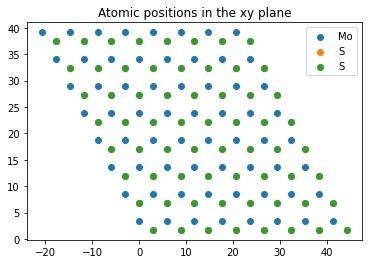

In [8]:
for pos in positions:
    plt.scatter(pos[1],pos[2],label=pos[0])
plt.title('Atomic positions in the xy plane',size=12)
plt.legend()

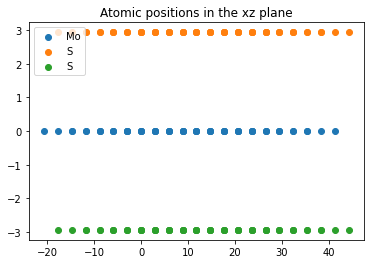

In [9]:
for pos in positions:
    plt.scatter(pos[1],pos[3],label=pos[0])
plt.title('Atomic positions in the xz plane',size=12)
plt.legend()

### Convergence procedure on the $k$-points sampling and of energy cutoff of the wave functions

We perform a set of calculations in functions of the number of k-points and of the energy cutoff and we find
the converged values using the total ground state energy, the gap at $K$ and the gap at $\Gamma$ as control quantities.

In [13]:
run_dir = 'DFT_analysis'

We build the basic elements of the input 

In [14]:
inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(28)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Mo',pseudo_name=Mo_pseudo,mass=42.00)
inp.add_atom(atom='S',pseudo_name=S_pseudo,mass=16.00)
inp.set_atoms_number(3)
inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
#inp.set_atomic_positions([['Mo',Mo_cryst],['S',S1_cryst],['S',S2_cryst]],type='crystal')
inp.set_lattice(ibrav=4,celldm1=alat,celldm3=celldm3)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 28,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 5.9000811881,
  'celldm(3)': 6.779567725386027},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo-fr.out'], 'S': [16.0, 'S-fr.out']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.49771232])],
   ['S', array([ 0.5       ,  0.28867513, -0.49771232])]]},
 'kpoints': {},
 'cell_parameters': {}}

In [15]:
kvalues = [12,15]
ecut = [40,60,80,100,120]

In [16]:
study = D.Dataset(run_dir=run_dir,num_tasks=4)

for k in kvalues:
    for e in ecut:
        idd = {'ecut' : e, 'k' : k}
        inp.set_prefix(D.name_from_id(idd))
        inp.set_kpoints(type='automatic',points=[k,k,1])
        inp.set_energy_cutoff(e)
        study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 4 parallel tasks


In [17]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9]] 

Run the task [0, 1, 2, 3] 
Skip the run of Skip the run ofecut_40-k_12
 Skip the run ofecut_60-k_12 
ecut_80-k_12
Skip the run of ecut_100-k_12
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
Skip the run of Skip the run of ecut_120-k_12ecut_40-k_15
Skip the run of
 ecut_60-k_15
Skip the run of ecut_80-k_15
Task [4, 5, 6, 7] ended 
 
Run the task [8, 9] 
Skip the run of ecut_100-k_15Skip the run of
 ecut_120-k_15
Task [8, 9] ended 
 


12 [-132.5864804257916, -132.5756487604389, -132.5574392301788, -132.5569581918037, -132.5569038022347]
15 [-132.5864648360196, -132.5756473112079, -132.5574393127679, -132.556958249201, -132.5569038818442]


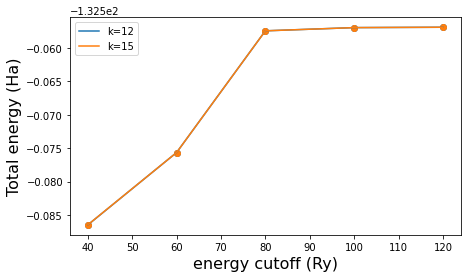

In [19]:
plt.figure(figsize=(7,4))
plt.xlabel('energy cutoff (Ry)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
for k in kvalues:
    energy =study.fetch_results(id={'k':k},attribute='energy')
    print(k,energy)
    plt.plot(ecut,energy,label='k=%s'%k)
    plt.scatter(ecut,energy)
plt.legend()

12 [1.7907601771405592, 1.779899368613452, 1.7822396629370505, 1.782107054963031, 1.7820979470666745]
15 [1.7905564359098394, 1.7799468072022848, 1.7822836169279013, 1.7822497635577297, 1.7821721352079174]


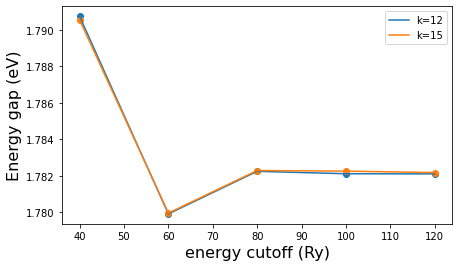

In [20]:
plt.figure(figsize=(7,4))
plt.xlabel('energy cutoff (Ry)',size=16)
plt.ylabel('Energy gap (eV)',size=16)
for k in kvalues:
    data = study.fetch_results(id={'k':k})    
    gap = [d.get_gap(verbose=False)['gap'] for d in data]
    print(k,gap)
    plt.plot(ecut,gap,label='k=%s'%k)
    plt.scatter(ecut,gap)
plt.legend()

12 [2.8366314290900174, 3.029014779004149, 3.0110235577398443, 3.010113660050341, 3.0100673561749383]
15 [2.8374166962313847, 3.029026197755989, 3.010997972857227, 3.010152923717392, 3.0099340122088796]


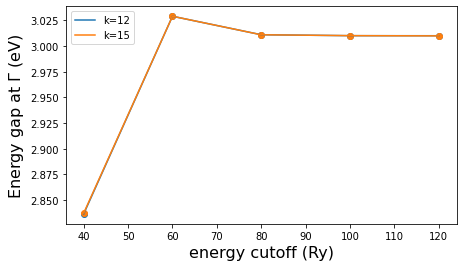

In [21]:
plt.figure(figsize=(7,4))
plt.xlabel('energy cutoff (Ry)',size=16)
plt.ylabel('Energy gap at $\Gamma$ (eV)',size=16)
for k in kvalues:
    data = study.fetch_results(id={'k':k})    
    gap_gamma = [d.get_evals()[0][26]- d.get_evals()[0][25] for d in data]
    print(k,gap_gamma)
    plt.plot(ecut,gap_gamma,label='k=%s'%k)
    plt.scatter(ecut,gap_gamma)
plt.legend()

On the basis of these results we choose

In [22]:
ecut_conv = 80 # energy cutoff on the wavefunction (Ry)
kpoints_conv = [12,12,1]

In [23]:
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='automatic',points=kpoints_conv)

### Calculation of the equilibrium lattice constants and buckling parameter

We determine the equiblrium values of the lattice constant and of the buckling parameter by minimizing
the GS energy

In [24]:
alat_range = 2 # alat percentage variation
alat_num = 5 # number of calculations
delta_range = 2 # buckling percentage variation
delta_num = 5 # number of calculations

alat_span = np.linspace(-alat_range/2,alat_range/2,alat_num)

delta_span = np.linspace(-delta_range/2,delta_range/2,delta_num)

alat_span, delta_span

(array([-1. , -0.5,  0. ,  0.5,  1. ]), array([-1. , -0.5,  0. ,  0.5,  1. ]))

In [26]:
study = D.Dataset(run_dir=run_dir,num_tasks=10)

for a_span in alat_span:
    for d_span in delta_span:
        a = alat*(1+a_span/100)
        d = delta*(1+d_span/100)
        
        Mo_cart = np.array([0,1./np.sqrt(3.),0.])
        S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),d])
        S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-d])
        idd = {'alat' : a_span, 'delta' : d_span}
        inp.set_prefix(D.name_from_id(idd))
        inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
        inp.set_lattice(ibrav=4,celldm1=a,celldm3=c/a)
        study.append_run(id=idd,input=inp,runner=code)
    
study.set_postprocessing_function(PP.pw_get_energy)
#study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 10 parallel tasks


In [27]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] with the parallel task_groups [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24]] 

Run the task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
Skip the run of Skip the run ofalat_-1.0-delta_-1.0
 alat_-1.0-delta_-0.5Skip the run of
 alat_-1.0-delta_0.0
Skip the run of alat_-1.0-delta_0.5
Skip the run of alat_-1.0-delta_1.0
Skip the run of alat_-0.5-delta_-1.0
Skip the run of alat_-0.5-delta_-0.5Skip the run of
 alat_-0.5-delta_0.0
Skip the run of alat_-0.5-delta_0.5
Skip the run of alat_-0.5-delta_1.0
Task [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ended 
 
Run the task [10, 11, 12, 13, 14, 15, 16, 17, 18, 19] 
Skip the run of Skip the run of
 alat_0.0-delta_-1.0alat_0.0-delta_-0.5Skip the run of
 alat_0.0-delta_0.0Skip the run of
 alat_0.0-delta_0.5
Skip the run of alat_0.0-delta_1.0Skip the run of
 alat_0.5-delta_-1.0
Skip the run of alat_0.5-delta_-0.5Skip 

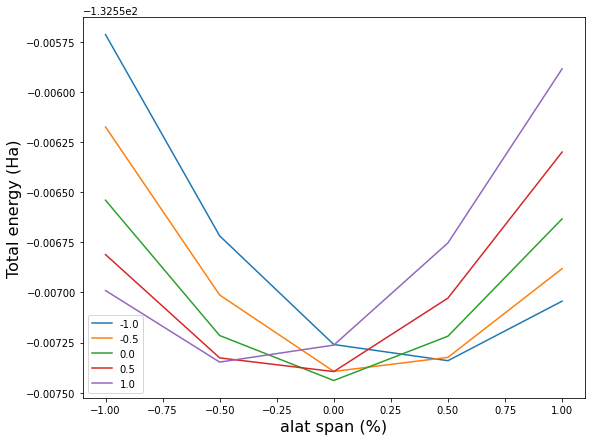

In [28]:
plt.figure(figsize=(9,7))
plt.xlabel('alat span (%)',size=16)
plt.ylabel('Total energy (Ha)',size=16)
for d_span in delta_span:
    energy =study.fetch_results(id={'delta':d_span})
    plt.plot(alat_span,energy,label=d_span)
plt.legend()

To find the optimal alat parameter we perform a quadratic fit of data (for delta=0)

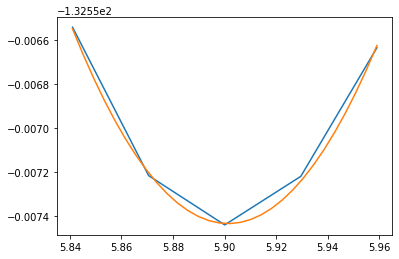

In [29]:
y =study.fetch_results(id={'delta':0.})
x = [alat*(1+a/100) for a in alat_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [30]:
x_eq = -coeffs[1]/(2*coeffs[0])
x_eq

5.901401607074741

In substantial agreement with the value already provided in the input.

In the same way the optimal buckling is 

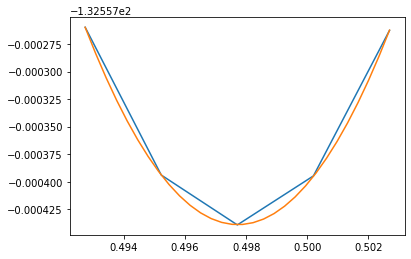

In [31]:
y =study.fetch_results(id={'alat':0.})
x = [delta*(1+a/100) for a in delta_span]
x_fit = np.linspace(x[0],x[-1],30)
coeffs = np.polyfit(x,y,2)
y_fit = [coeffs[0]*xx**2+coeffs[1]*xx+coeffs[2] for xx in x_fit]
plt.plot(x,y)
plt.plot(x_fit,y_fit)

In [49]:
x_eq = -coeffs[1]/(2*coeffs[0])
x_eq

0.497730467484591

### Converged ground states

Finally we perform a last scf calculation with converged parameters

In [4]:
run_dir = 'DFT_analysis'
pseudo_dir = '../pseudos'
Mo_pseudo = 'Mo-fr.out'
S_pseudo = 'S-fr.out'

alat_conv =  5.90140607 # in a.u. (Bohr)
delta_conv = 0.49773047 # in units of alat
c = 40.0 # vacuum distance in a.u. 

ecut_conv = 80 # energy cutoff on the wavefunction (Ry)
kpoints_conv = [12,12,1]

Mo_cart = np.array([0,1./np.sqrt(3.),0.])
S1_cart = np.array([1./2.,1./(2*np.sqrt(3.)),delta_conv])
S2_cart = np.array([1./2.,1./(2*np.sqrt(3.)),-delta_conv])

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_num_bnds(28)
inp.set_pseudo_dir(pseudo_dir=pseudo_dir)
inp.set_spinorbit()
inp.add_atom(atom='Mo',pseudo_name=Mo_pseudo,mass=42.00)
inp.add_atom(atom='S',pseudo_name=S_pseudo,mass=16.00)
inp.set_atoms_number(3)
inp.set_atomic_positions([['Mo',Mo_cart],['S',S1_cart],['S',S2_cart]],type='alat')
inp.set_lattice(ibrav=4,celldm1=alat_conv,celldm3=c/alat_conv)
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='automatic',points=kpoints_conv)
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 28,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 5.90140607,
  'celldm(3)': 6.7780456937781945,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo-fr.out'], 'S': [16.0, 'S-fr.out']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.49773047])],
   ['S', array([ 0.5       ,  0.28867513, -0.49773047])]]},
 'kpoints': {'type': 'automatic', 'values': ([12, 12, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [12]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)

idd = 'gs_converged'
inp.set_prefix(D.name_from_id(idd))
study.append_run(id=idd,input=inp,runner=code)
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 1 parallel tasks


In [13]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of gs_converged
Task [0] ended 
 


In [14]:
results[0].get_gap()

Direct gap system
Gap : 1.7805438740579023 eV


{'gap': 1.7805438740579023,
 'direct_gap': 1.7805438740579023,
 'position_cbm': 18,
 'positon_vbm': 18}

Gap at $\Gamma$

In [15]:
results[0].get_evals()[0][26]- results[0].get_evals()[0][25]

3.008639241620685

## Band structure on high symmetry line

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b type of
pw) and we make usage of the function build_kpath

In [5]:
bands_prefix = 'bands'
G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path

In [6]:
klist = Tools.build_pw_kpath(G,Mp,Kp,G,numstep=60)
klist

[[0.0, 0.0, 0.0, 60],
 [0.0, 0.5773502691896258, 0.0, 60],
 [0.3333333333333333, 0.5773502691896258, 0.0, 60],
 [0.0, 0.0, 0.0, 0]]

In [7]:
inp.set_bands(30,force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 30,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 5.90140607,
  'celldm(3)': 6.7780456937781945,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo-fr.out'], 'S': [16.0, 'S-fr.out']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.49773047])],
   ['S', array([ 0.5       ,  0.28867513, -0.49773047])]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.0, 0.0, 0.0, 60],
   [0.0, 0.5773502691896258, 0.0, 60],
   [0.3333333333333333, 0.5773502691896258, 0.0, 60],
   [0.0, 0.0, 0.0, 0]]},
 'cell_parameters': {}}

In [8]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir='DFT_analysis/gs_converged.save')

Skip the run of bands
The folder /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/DFT_analysis/bands.save already exists. Source_dir DFT_analysis/gs_converged.save not copied


Once that the computation is over we can create an instance of PwBands

In [9]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [10]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'M'],
 [0.0, 1.577350265701805, 0.9106835999999988, 0.57735027])

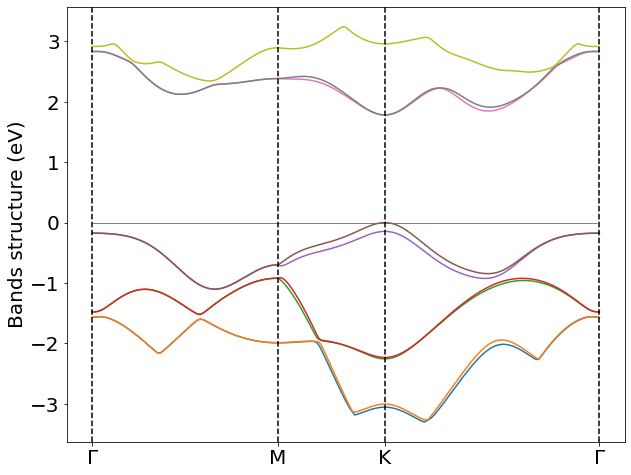

In [12]:
label_size = 20

fig, ax = plt.subplots(figsize=(10, 8))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(20,29)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

## NSCF computations on regular grids

We set up the nscf computations on regular grids.

In agreement with the input provided by Fulvio Paleari we use  a 42x42x1 k-poinst sampling and 250 empty bands.

In [5]:
Gamma = np.array([0.,0.])
K = np.array([2./3.,0])
M = np.array([1./2.,1./(2*np.sqrt(3))])
Kp = np.array([1./3.,1./np.sqrt(3)])
Mp = np.array([0.,1./np.sqrt(3)])

In [6]:
nbnds = 250
inp.set_nscf(nbnds,force_symmorphic=True,conv_thr=1e-6)
inp

{'control': {'calculation': "'nscf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 250,
  'lspinorb': '.true.',
  'noncolin': '.true.',
  'ntyp': '2',
  'nat': '3',
  'ibrav': 4,
  'celldm(1)': 5.90140607,
  'celldm(3)': 6.7780456937781945,
  'ecutwfc': 80},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Mo': [42.0, 'Mo-fr.out'], 'S': [16.0, 'S-fr.out']},
 'atomic_positions': {'type': 'alat',
  'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
   ['S', array([0.5       , 0.28867513, 0.49773047])],
   ['S', array([ 0.5       ,  0.28867513, -0.49773047])]]},
 'kpoints': {'type': 'automatic', 'values': ([12, 12, 1], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [7]:
kvalues = [18,30,42]

In [8]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)
study.set_postprocessing_function(PP.pw_parse_data)

for k in kvalues:
    idd = {'kpoints':k,'nbnds':nbnds}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,k,1])
    study.append_run(id=idd,input=inp,runner=code,source_dir='DFT_analysis/gs_converged.save')

Initialize a Dataset with 1 parallel tasks


In [9]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'DFT_analysis',
 'num_tasks': 1,
 'verbose': True,
 'input': {'control': {'calculation': "'nscf'",
   'verbosity': "'high'",
   'prefix': "'kpoints_18-nbnds_250'",
   'outdir': "'./'",
   'pseudo_dir': "'../pseudos'"},
  'system': {'force_symmorphic': '.true.',
   'nbnd': 250,
   'lspinorb': '.true.',
   'noncolin': '.true.',
   'ntyp': '2',
   'nat': '3',
   'ibrav': 4,
   'celldm(1)': 5.90140607,
   'celldm(3)': 6.7780456937781945,
   'ecutwfc': 80},
  'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
  'ions': {},
  'cell': {},
  'atomic_species': {'Mo': [42.0, 'Mo-fr.out'], 'S': [16.0, 'S-fr.out']},
  'atomic_positions': {'type': 'alat',
   'values': [['Mo', array([0.        , 0.57735027, 0.        ])],
    ['S', array([0.5       , 0.28867513, 0.49773047])],
    ['S', array([ 0.5       ,  0.28867513, -0.49773047])]]},
  'kpoints': {'type': 'automatic', 'values': ([18, 18, 1], [0.0, 0.0, 0.0])},
  'cell_parameters': {}},
 'source_dir': '

In [10]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of kpoints_18-nbnds_250
The folder /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/DFT_analysis/kpoints_18-nbnds_250.save already exists. Source_dir DFT_analysis/gs_converged.save not copied
Task [0] ended 
 
Run the task [1] 
Skip the run of kpoints_30-nbnds_250
The folder /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/DFT_analysis/kpoints_30-nbnds_250.save already exists. Source_dir DFT_analysis/gs_converged.save not copied
Task [1] ended 
 
Run the task [2] 
Skip the run of kpoints_42-nbnds_250
The folder /work/dalessandro/2D_ELECTRONIC_OPTICAL_PROPERTIES/MoS2/DFT_analysis/kpoints_42-nbnds_250.save already exists. Source_dir DFT_analysis/gs_converged.save not copied
Task [2] ended 
 


In [15]:
kp = results[2].kpoints # cartesian coordinates in units of 2\pi/alat

number of kpoints = 169


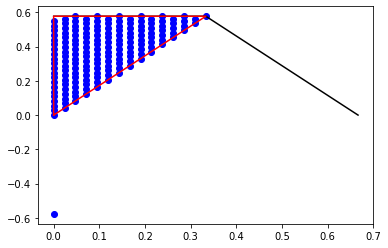

In [16]:
BZ = [K, Kp, Mp]
print('number of kpoints = %s'%len(kp))
plt.plot(*np.column_stack(BZ),color='black')
IBZ = [Gamma,Kp, Mp,Gamma]
plt.plot(*np.column_stack(IBZ),color='red')
plt.scatter(kp[:,0],kp[:,1],c='blue')